In [1]:
# !pip install -q lightly
# !pip install -q scikit-dimension

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# To be able to import from parent directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [12]:
from utils import model_param_count, plot_images
from utils import IndexedDataset, RepresentationBuffer, MeanSquareDistancesStat

import random

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as T

DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
SEED=42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(DEVICE)

cuda:0


## Self-Supervised Contrastive Models

## Barlow Twins
https://arxiv.org/abs/2103.03230

In [112]:
from lightly.loss import BarlowTwinsLoss
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.transforms.byol_transform import (
    BYOLView1Transform,
    BYOLView2Transform,
    MultiViewTransform
)
from lightly.transforms.utils import IMAGENET_NORMALIZE

class BarlowTwins(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def encode(self, x):
        return self.backbone(x).flatten(start_dim=1)

In [113]:
CHS = 3
IMG_SIZE = (32, 32)
BS = 512

class BYOLTransformWrapped(MultiViewTransform):
        """Appends BYOL transform output with not augmented images"""
        def __init__(self, view_1_transform, view_2_transform):
                view_1_transform = view_1_transform or BYOLView1Transform()
                view_2_transform = view_2_transform or BYOLView2Transform()
                transforms = [
                        T.Compose([T.ToTensor(), T.Normalize(mean=IMAGENET_NORMALIZE["mean"], std=IMAGENET_NORMALIZE["std"])]),
                        view_1_transform, 
                        view_2_transform
                ]
                super().__init__(transforms=transforms)


transform_train = BYOLTransformWrapped( # note: this thing works only with 3
        view_1_transform=BYOLView1Transform(input_size=IMG_SIZE[0], gaussian_blur=0.0),
        view_2_transform=BYOLView2Transform(input_size=IMG_SIZE[0], gaussian_blur=0.0),
)

ds_train = IndexedDataset(datasets.CIFAR10(root='../data', transform=transform_train, download=True))
train_loader = DataLoader(ds_train, batch_size=BS, shuffle=True, drop_last=False)

Files already downloaded and verified


In [114]:
len(ds_train), next(iter(train_loader))[1][0].shape

(50000, torch.Size([512, 3, 32, 32]))

In [115]:
backbone = nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])
print(model_param_count(backbone))

11176512


In [117]:
# MSD experiment
import gc

NUM_EPOCHS=75

model = BarlowTwins(backbone).to(DEVICE)
criterion = BarlowTwinsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
repr_buffer = RepresentationBuffer(len(ds_train), 512)
msd_tracker = MeanSquareDistancesStat(len(ds_train), NUM_EPOCHS, 512, repr_buffer)

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for idx, x, _ in train_loader:
        model.train()
        x_orig, x0, x1 = x
        x_orig = x_orig.to(DEVICE)
        x0 = x0.to(DEVICE)
        x1 = x1.to(DEVICE)

        projection_0 = model(x0)
        projection_1 = model(x1)

        loss = criterion(projection_0, projection_1)
        total_loss += loss.detach()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            z = model.encode(x_orig) # note: repr obtained only from backbone
            z = z.cpu()
            msd_tracker.push((idx, z))

    avg_loss = total_loss / len(train_loader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    msd_tracker.inc_epoch()

    torch.cuda.empty_cache()
    gc.collect()

    print(f"mean msd: {np.mean(msd_tracker.msd_hist[epoch].cpu().detach().numpy()):.3f}")


# save tensor with msd hist for later
torch.save(msd_tracker.msd_hist, '../data/msd_hist.pt')

epoch: 00, loss: 1346.52673
mean msd: 0.000
epoch: 01, loss: 1104.99292
mean msd: 3.454
epoch: 02, loss: 987.48816
mean msd: 3.924
epoch: 03, loss: 911.66156
mean msd: 4.202
epoch: 04, loss: 857.57617
mean msd: 4.371
epoch: 05, loss: 826.60895
mean msd: 4.554
epoch: 06, loss: 787.62262
mean msd: 4.621
epoch: 07, loss: 756.25787
mean msd: 4.681
epoch: 08, loss: 733.29926
mean msd: 4.776
epoch: 09, loss: 711.81152
mean msd: 4.605
epoch: 10, loss: 692.16437
mean msd: 4.645
epoch: 11, loss: 672.34894
mean msd: 4.436
epoch: 12, loss: 660.42096
mean msd: 4.380
epoch: 13, loss: 647.53735
mean msd: 4.255
epoch: 14, loss: 637.78455
mean msd: 4.215
epoch: 15, loss: 622.81372
mean msd: 4.257
epoch: 16, loss: 613.97748
mean msd: 4.236
epoch: 17, loss: 605.77643
mean msd: 4.029
epoch: 18, loss: 595.20312
mean msd: 4.040
epoch: 19, loss: 587.51410
mean msd: 3.960
epoch: 20, loss: 584.26337
mean msd: 3.938
epoch: 21, loss: 571.32288
mean msd: 3.814
epoch: 22, loss: 569.38385
mean msd: 3.874
epoch: 23

## MSD analysis

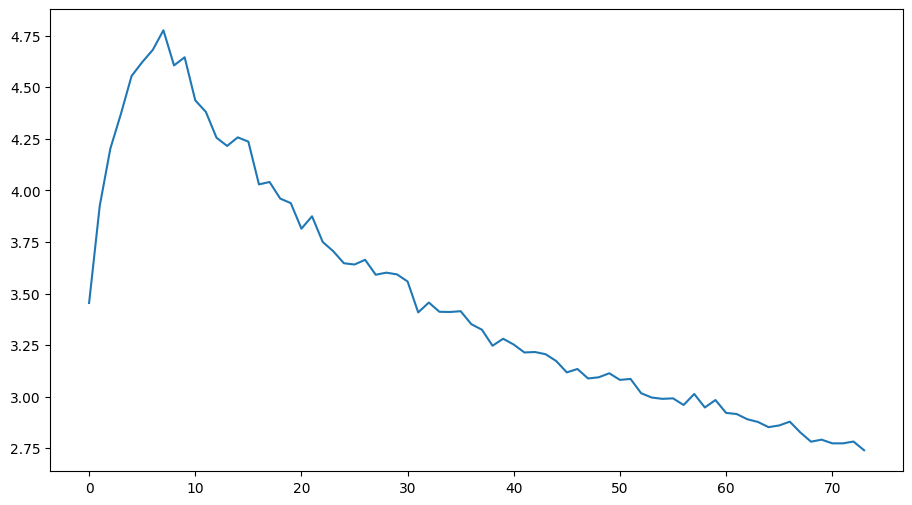

In [119]:
plt.figure(figsize=(11, 6))
msd_hist = np.array(msd_tracker.msd_hist[1:NUM_EPOCHS])
plt.plot(msd_hist.mean(axis=1))
plt.show()

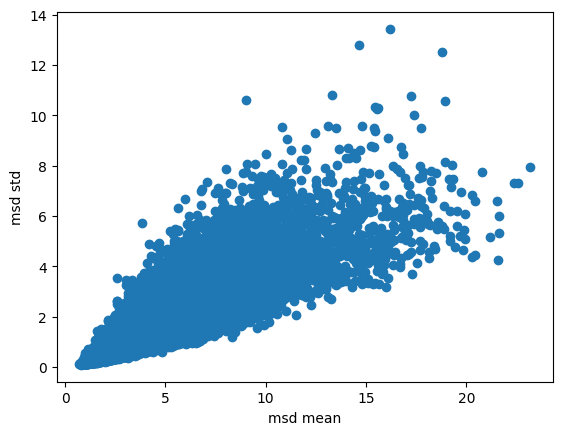

In [122]:
# mean and std of each sample msd
msd_means = msd_hist.mean(axis=0)
msd_stds = msd_hist.std(axis=0)

# plot scatter plot
plt.scatter(msd_means, msd_stds)
plt.xlabel('msd mean')
plt.ylabel('msd std')
plt.show()

### Samples by MSD

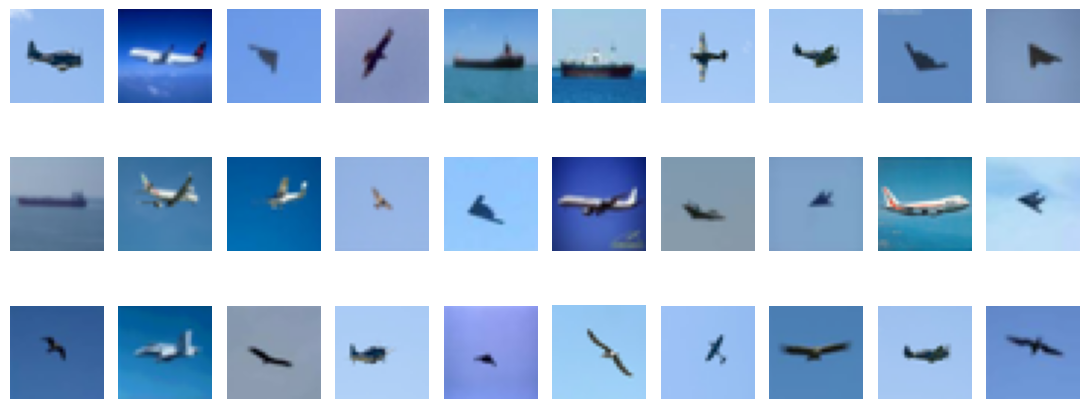

In [126]:
# images with maximum mean msd
N=30
imgs = torch.cat([ds_train[idx][1][0].reshape(1, 3, 32, 32) for idx in np.argsort(msd_means)[-N:]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], n=N) 

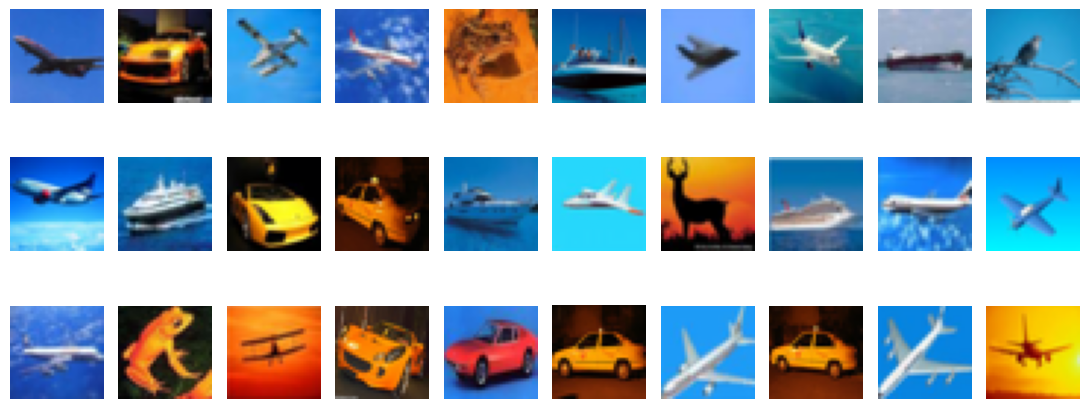

In [127]:
# images with max mean std of msd
imgs = torch.cat([ds_train[idx][1][0].reshape(1, 3, 32, 32) for idx in np.argsort(msd_stds)[-N:]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], N)

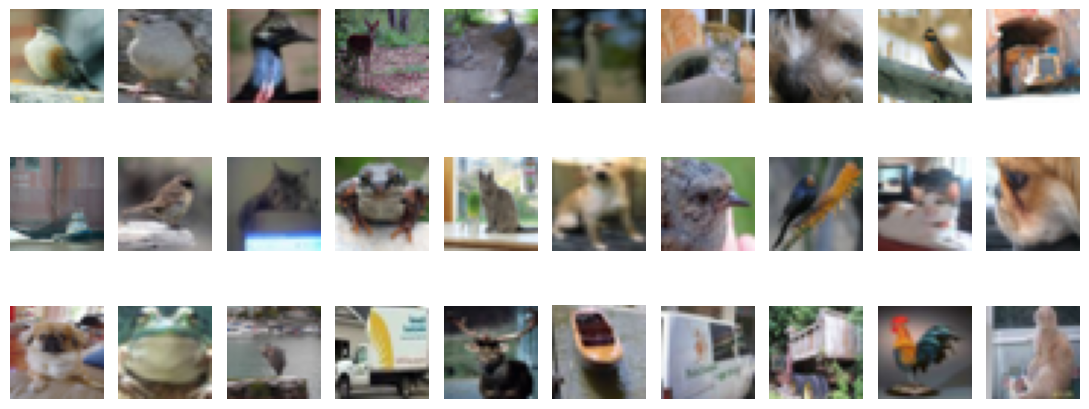

In [129]:
#msd_means_no_zeros = msd_means[np.isclose(msd_means, 1e-6)]

sorted_idx = np.argsort(msd_means)
imgs = torch.cat([ds_train[idx][1][0].reshape(1, 3, 32, 32) for idx in sorted_idx[:N]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], N) 

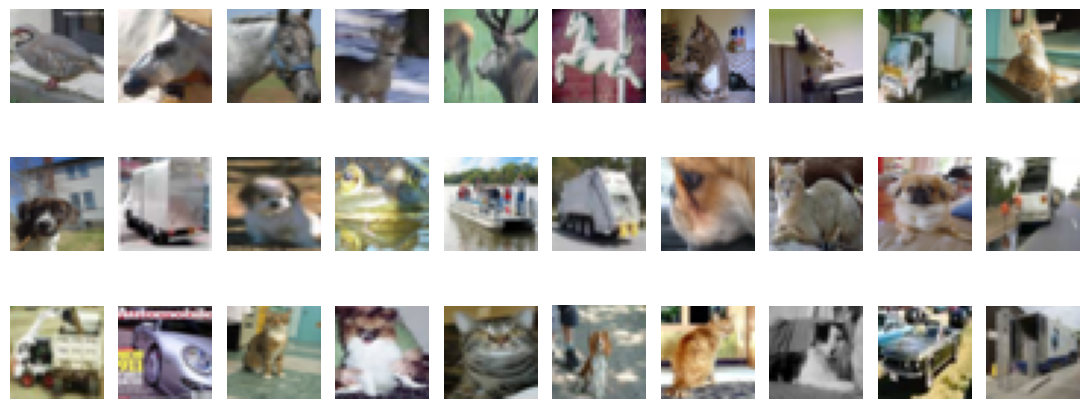

In [130]:
sorted_idx = np.argsort(msd_stds)
sorted_idx = sorted_idx[80:] # remove zeros caused by removed last batch
imgs = torch.cat([ds_train[idx][1][0].reshape(1, 3, 32, 32) for idx in sorted_idx[:N]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], N) 

### Plot MSD through epochs of "easiest" and "hardest"

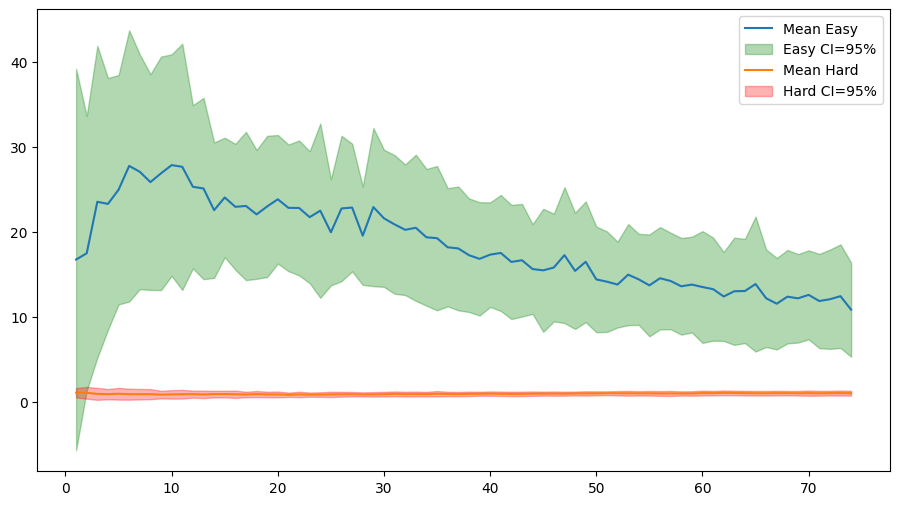

In [144]:
# Easy and hard by msd mean
M=100
easy_idx = np.argsort(msd_means)[-M:]
hard_idx = np.argsort(msd_means)[:M]

plt.figure(figsize=(11, 6))
msd_easy_hist = np.array(msd_tracker.msd_hist[1:NUM_EPOCHS, easy_idx])
easy_mean = np.mean(msd_easy_hist, axis=1)
easy_std = np.std(msd_easy_hist, axis=1)
plt.plot(list(range(1, 75)), easy_mean, label='Mean Easy')
plt.fill_between(list(range(1, 75)), easy_mean - 1.96*easy_std, easy_mean + 1.96*easy_std, color='green', alpha=0.3, label='Easy CI=95%')


msd_hard_hist = np.array(msd_tracker.msd_hist[1:NUM_EPOCHS, hard_idx])
hard_mean = np.mean(msd_hard_hist, axis=1)
hard_std = np.std(msd_hard_hist, axis=1)
plt.plot(list(range(1, 75)), hard_mean, label='Mean Hard')
plt.fill_between(list(range(1, 75)), hard_mean - 1.96*hard_std, hard_mean + 1.96*hard_std, color='red', alpha=0.3, label='Hard CI=95%')

plt.legend()
plt.fill
plt.show()

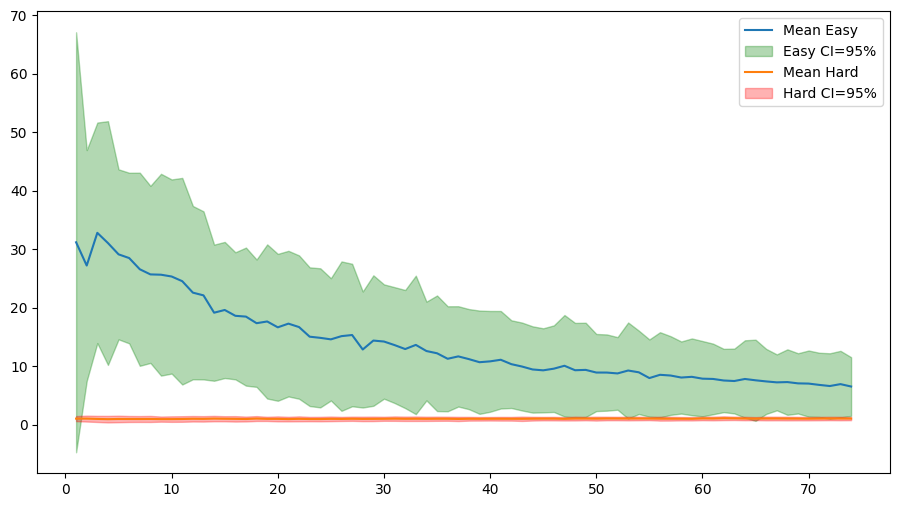

In [148]:
# Easy and hard by msd std

M=100
easy_idx = np.argsort(msd_stds)[-M:]
hard_idx = np.argsort(msd_stds)[:M]

plt.figure(figsize=(11, 6))
msd_easy_hist = np.array(msd_tracker.msd_hist[1:NUM_EPOCHS, easy_idx])
easy_mean = np.mean(msd_easy_hist, axis=1)
easy_std = np.std(msd_easy_hist, axis=1)
plt.plot(list(range(1, 75)), easy_mean, label='Mean Easy')
plt.fill_between(list(range(1, 75)), easy_mean - 1.96*easy_std, easy_mean + 1.96*easy_std, color='green', alpha=0.3, label='Easy CI=95%')


msd_hard_hist = np.array(msd_tracker.msd_hist[1:NUM_EPOCHS, hard_idx])
hard_mean = np.mean(msd_hard_hist, axis=1)
hard_std = np.std(msd_hard_hist, axis=1)
plt.plot(list(range(1, 75)), hard_mean, label='Mean Hard')
plt.fill_between(list(range(1, 75)), hard_mean - 1.96*hard_std, hard_mean + 1.96*hard_std, color='red', alpha=0.3, label='Hard CI=95%')

plt.legend()
plt.fill
plt.show()

## Experiment: remove 30% from of 'easy' samples from train, compare quality of trained model

In [10]:
# load msd hist

msd_hist = torch.load('../data/msd_hist.pt').numpy()

msd_means = np.mean(msd_hist, axis=0)

In [11]:
from torch.utils.data import Dataset

class DatasetCompressed(Dataset):
    def __init__(self, ds, idx_to_remove):
        super().__init__()
        data = ds.data
        mask = np.ones(len(data), dtype=bool)
        mask[idx_to_remove] = False
        self.data = data[mask]
        self.targets = np.array(ds.targets)[mask]
        self.transform = ds.transform
        self.target_transform = ds.target_transform

    def __getitem__(self, idx):
        if idx < 0 or idx > len(self.data): raise ValueError
        img, target = self.data[idx], self.targets[idx]
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

In [12]:
from sklearn.metrics import accuracy_score

def epoch_train(loader, clf, criterion, opt):
    # BEGIN Solution (do not delete this comment!)
    clf.train()
    train_losses, train_accs = [], []
    for idx, (x, y) in enumerate(loader):
        opt.zero_grad()

        y = y.to(torch.int64)
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = clf(x)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy_score(
            y.detach().cpu().numpy(),
            torch.argmax(logits, axis=1).detach().cpu().numpy()
        ))

    return np.mean(train_losses), np.mean(train_accs)

    # END Solution (do not delete this comment!)

def epoch_test(loader, clf, criterion):
    # BEGIN Solution (do not delete this comment!)
    clf.eval()
    test_losses, test_accs = [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            logits = clf(x)
            loss = criterion(logits, y)
            y_pred = torch.argmax(logits, axis=1)
            acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())

            test_losses.append(loss.item())
            test_accs.append(acc)

    return np.mean(test_losses), np.mean(test_accs)
    # END Solution (do not delete this comment!)

# The function which you are going to use for model training
def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' +
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [13]:
import torchvision.transforms.v2 as T

N_TO_REMOVE = int(0.3*50_000)
easy_to_remove = np.argsort(msd_means)[-N_TO_REMOVE:]

N_TO_CHOOSE = int(0.67 * 50_000)
random_choices = np.random.choice(50_000, size=N_TO_CHOOSE, replace=False)

BS = 128
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transform_clf = T.Compose([
    T.Resize((32, 32)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.Normalize(mean=MEAN, std=STD),
])

test_transform_clf = T.Compose([
    T.Resize((32, 32)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=MEAN, std=STD),
])

ds_train = datasets.CIFAR10(root='../data', transform=train_transform_clf, download=True)
ds_test = datasets.CIFAR10(root='../data', train=False, transform=test_transform_clf, download=True)

ds_train_compressed = DatasetCompressed(
    ds_train,
    easy_to_remove
)

ds_train_randomed = DatasetCompressed(
    ds_train,
    random_choices
)

train_loader = DataLoader(ds_train, batch_size=BS, shuffle=True, drop_last=False)
train_loader_compressed = DataLoader(ds_train_compressed, batch_size=BS, shuffle=True, drop_last=False)
train_loader_randomed = DataLoader(ds_train_compressed, batch_size=BS, shuffle=True, drop_last=False)

test_loader = DataLoader(ds_test, batch_size=BS, shuffle=False, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


In [167]:
# 1. firstly train model on full dataset
clf = torchvision.models.vgg16_bn().to(DEVICE)
opt = torch.optim.Adam(params=clf.parameters(), lr=3e-4)
criterion = F.cross_entropy

train(train_loader, test_loader, clf, criterion, opt, n_epochs=50)

  2%|███▍                                                                                                                                                                        | 1/50 [02:11<1:47:34, 131.72s/it]

[Epoch 1] train loss: 2.314; train acc: 0.18; test loss: 1.806; test acc: 0.28


  4%|██████▉                                                                                                                                                                     | 2/50 [04:24<1:45:57, 132.44s/it]

[Epoch 2] train loss: 1.657; train acc: 0.36; test loss: 1.343; test acc: 0.49


  6%|██████████▎                                                                                                                                                                 | 3/50 [06:34<1:42:42, 131.11s/it]

[Epoch 3] train loss: 1.348; train acc: 0.52; test loss: 1.228; test acc: 0.57


  8%|█████████████▊                                                                                                                                                              | 4/50 [08:43<1:39:55, 130.33s/it]

[Epoch 4] train loss: 1.161; train acc: 0.60; test loss: 0.962; test acc: 0.67


 10%|█████████████████▏                                                                                                                                                          | 5/50 [10:52<1:37:25, 129.89s/it]

[Epoch 5] train loss: 0.995; train acc: 0.66; test loss: 0.846; test acc: 0.71


 12%|████████████████████▋                                                                                                                                                       | 6/50 [13:03<1:35:33, 130.30s/it]

[Epoch 6] train loss: 0.910; train acc: 0.70; test loss: 0.755; test acc: 0.75


 14%|████████████████████████                                                                                                                                                    | 7/50 [15:12<1:33:08, 129.97s/it]

[Epoch 7] train loss: 0.879; train acc: 0.71; test loss: 0.773; test acc: 0.76


 16%|███████████████████████████▌                                                                                                                                                | 8/50 [17:23<1:31:12, 130.30s/it]

[Epoch 8] train loss: 0.779; train acc: 0.74; test loss: 0.662; test acc: 0.78


 18%|██████████████████████████████▉                                                                                                                                             | 9/50 [19:32<1:28:35, 129.65s/it]

[Epoch 9] train loss: 0.752; train acc: 0.76; test loss: 0.590; test acc: 0.80


 20%|██████████████████████████████████▏                                                                                                                                        | 10/50 [21:38<1:25:50, 128.75s/it]

[Epoch 10] train loss: 0.777; train acc: 0.75; test loss: 0.619; test acc: 0.80


 22%|█████████████████████████████████████▌                                                                                                                                     | 11/50 [23:49<1:24:00, 129.23s/it]

[Epoch 11] train loss: 0.683; train acc: 0.78; test loss: 0.622; test acc: 0.80


 24%|█████████████████████████████████████████                                                                                                                                  | 12/50 [26:03<1:22:52, 130.84s/it]

[Epoch 12] train loss: 0.624; train acc: 0.80; test loss: 0.527; test acc: 0.82


 26%|████████████████████████████████████████████▍                                                                                                                              | 13/50 [28:22<1:22:14, 133.35s/it]

[Epoch 13] train loss: 0.617; train acc: 0.80; test loss: 0.776; test acc: 0.74


 28%|███████████████████████████████████████████████▉                                                                                                                           | 14/50 [30:34<1:19:38, 132.74s/it]

[Epoch 14] train loss: 0.674; train acc: 0.79; test loss: 0.522; test acc: 0.83


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 15/50 [32:46<1:17:26, 132.76s/it]

[Epoch 15] train loss: 0.590; train acc: 0.81; test loss: 0.521; test acc: 0.83


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 16/50 [35:03<1:15:51, 133.88s/it]

[Epoch 16] train loss: 0.553; train acc: 0.82; test loss: 0.495; test acc: 0.83


 34%|██████████████████████████████████████████████████████████▏                                                                                                                | 17/50 [37:15<1:13:20, 133.35s/it]

[Epoch 17] train loss: 0.645; train acc: 0.80; test loss: 1.129; test acc: 0.61


 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 18/50 [39:29<1:11:08, 133.40s/it]

[Epoch 18] train loss: 0.579; train acc: 0.82; test loss: 0.472; test acc: 0.84


 38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 19/50 [41:41<1:08:47, 133.15s/it]

[Epoch 19] train loss: 0.490; train acc: 0.84; test loss: 0.437; test acc: 0.85


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 20/50 [43:58<1:07:03, 134.13s/it]

[Epoch 20] train loss: 0.568; train acc: 0.82; test loss: 0.453; test acc: 0.85


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                   | 21/50 [46:13<1:04:59, 134.46s/it]

[Epoch 21] train loss: 0.478; train acc: 0.85; test loss: 0.431; test acc: 0.86


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                               | 22/50 [48:28<1:02:51, 134.71s/it]

[Epoch 22] train loss: 0.450; train acc: 0.85; test loss: 0.405; test acc: 0.86


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                            | 23/50 [50:42<1:00:32, 134.53s/it]

[Epoch 23] train loss: 0.418; train acc: 0.86; test loss: 0.407; test acc: 0.86


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 24/50 [52:54<57:53, 133.61s/it]

[Epoch 24] train loss: 0.459; train acc: 0.85; test loss: 0.459; test acc: 0.85


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 25/50 [55:07<55:37, 133.51s/it]

[Epoch 25] train loss: 0.500; train acc: 0.84; test loss: 0.463; test acc: 0.86


 52%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 26/50 [57:23<53:41, 134.24s/it]

[Epoch 26] train loss: 0.417; train acc: 0.87; test loss: 0.439; test acc: 0.85


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 27/50 [59:41<51:54, 135.43s/it]

[Epoch 27] train loss: 0.412; train acc: 0.87; test loss: 0.496; test acc: 0.86


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 28/50 [1:01:58<49:47, 135.78s/it]

[Epoch 28] train loss: 0.437; train acc: 0.86; test loss: 0.424; test acc: 0.86


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 29/50 [1:04:11<47:13, 134.94s/it]

[Epoch 29] train loss: 0.367; train acc: 0.88; test loss: 0.397; test acc: 0.87


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 30/50 [1:06:20<44:27, 133.38s/it]

[Epoch 30] train loss: 0.396; train acc: 0.87; test loss: 0.423; test acc: 0.87


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 31/50 [1:08:27<41:37, 131.43s/it]

[Epoch 31] train loss: 0.799; train acc: 0.74; test loss: 0.546; test acc: 0.82


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 32/50 [1:10:39<39:27, 131.51s/it]

[Epoch 32] train loss: 0.485; train acc: 0.84; test loss: 0.462; test acc: 0.85


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 33/50 [1:12:53<37:26, 132.14s/it]

[Epoch 33] train loss: 0.464; train acc: 0.85; test loss: 0.447; test acc: 0.86


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 34/50 [1:15:02<35:00, 131.29s/it]

[Epoch 34] train loss: 0.382; train acc: 0.88; test loss: 0.390; test acc: 0.87


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 35/50 [1:17:13<32:50, 131.34s/it]

[Epoch 35] train loss: 0.364; train acc: 0.88; test loss: 0.411; test acc: 0.87


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 36/50 [1:19:31<31:05, 133.25s/it]

[Epoch 36] train loss: 0.381; train acc: 0.88; test loss: 0.388; test acc: 0.87


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 37/50 [1:21:42<28:44, 132.68s/it]

[Epoch 37] train loss: 0.320; train acc: 0.89; test loss: 0.410; test acc: 0.87


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 38/50 [1:23:57<26:40, 133.37s/it]

[Epoch 38] train loss: 0.314; train acc: 0.90; test loss: 0.417; test acc: 0.87


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 39/50 [1:26:16<24:44, 134.98s/it]

[Epoch 39] train loss: 0.334; train acc: 0.90; test loss: 0.415; test acc: 0.87


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 40/50 [1:28:31<22:30, 135.06s/it]

[Epoch 40] train loss: 0.288; train acc: 0.90; test loss: 0.369; test acc: 0.88


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 41/50 [1:30:48<20:20, 135.60s/it]

[Epoch 41] train loss: 0.316; train acc: 0.90; test loss: 1.022; test acc: 0.69


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 42/50 [1:33:01<17:58, 134.81s/it]

[Epoch 42] train loss: 0.397; train acc: 0.87; test loss: 0.390; test acc: 0.87


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 43/50 [1:35:16<15:43, 134.78s/it]

[Epoch 43] train loss: 0.283; train acc: 0.91; test loss: 0.377; test acc: 0.88


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 44/50 [1:37:31<13:29, 134.86s/it]

[Epoch 44] train loss: 0.352; train acc: 0.89; test loss: 0.407; test acc: 0.87


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 45/50 [1:39:47<11:16, 135.24s/it]

[Epoch 45] train loss: 0.258; train acc: 0.91; test loss: 0.360; test acc: 0.88


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 46/50 [1:42:01<08:59, 134.91s/it]

[Epoch 46] train loss: 0.329; train acc: 0.90; test loss: 0.420; test acc: 0.86


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 47/50 [1:44:14<06:43, 134.34s/it]

[Epoch 47] train loss: 0.398; train acc: 0.87; test loss: 0.395; test acc: 0.87


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 48/50 [1:46:26<04:27, 133.67s/it]

[Epoch 48] train loss: 0.297; train acc: 0.91; test loss: 0.408; test acc: 0.87


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [1:48:40<02:13, 133.65s/it]

[Epoch 49] train loss: 0.254; train acc: 0.92; test loss: 0.408; test acc: 0.87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:50:55<00:00, 133.12s/it]

[Epoch 50] train loss: 0.230; train acc: 0.92; test loss: 0.414; test acc: 0.88


In [8]:
# 2. now train model on compressed dataset
clf = torchvision.models.vgg16_bn().to(DEVICE)
opt = torch.optim.Adam(params=clf.parameters(), lr=3e-4)
criterion = F.cross_entropy

train(train_loader_compressed, test_loader, clf, criterion, opt, n_epochs=50)

  2%|███▍                                                                                                                                                                         | 1/50 [01:31<1:14:23, 91.09s/it]

[Epoch 1] train loss: 2.645; train acc: 0.14; test loss: 1.951; test acc: 0.18


  4%|██████▉                                                                                                                                                                      | 2/50 [03:01<1:12:32, 90.67s/it]

[Epoch 2] train loss: 1.966; train acc: 0.22; test loss: 1.814; test acc: 0.23


  6%|██████████▍                                                                                                                                                                  | 3/50 [04:29<1:09:57, 89.31s/it]

[Epoch 3] train loss: 1.812; train acc: 0.28; test loss: 1.580; test acc: 0.39


  8%|█████████████▊                                                                                                                                                               | 4/50 [05:58<1:08:37, 89.51s/it]

[Epoch 4] train loss: 1.639; train acc: 0.38; test loss: 1.347; test acc: 0.52


 10%|█████████████████▎                                                                                                                                                           | 5/50 [07:31<1:08:04, 90.76s/it]

[Epoch 5] train loss: 1.434; train acc: 0.48; test loss: 1.163; test acc: 0.59


 12%|████████████████████▊                                                                                                                                                        | 6/50 [08:58<1:05:37, 89.48s/it]

[Epoch 6] train loss: 1.287; train acc: 0.55; test loss: 1.069; test acc: 0.63


 14%|████████████████████████▏                                                                                                                                                    | 7/50 [10:26<1:03:36, 88.75s/it]

[Epoch 7] train loss: 1.142; train acc: 0.61; test loss: 0.910; test acc: 0.70


 16%|███████████████████████████▋                                                                                                                                                 | 8/50 [11:51<1:01:16, 87.53s/it]

[Epoch 8] train loss: 1.076; train acc: 0.64; test loss: 0.883; test acc: 0.71


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [13:18<59:42, 87.37s/it]

[Epoch 9] train loss: 0.976; train acc: 0.68; test loss: 0.787; test acc: 0.75


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [14:45<58:14, 87.35s/it]

[Epoch 10] train loss: 0.922; train acc: 0.70; test loss: 0.754; test acc: 0.77


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [16:13<56:49, 87.43s/it]

[Epoch 11] train loss: 0.856; train acc: 0.72; test loss: 0.715; test acc: 0.78


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [17:39<55:11, 87.14s/it]

[Epoch 12] train loss: 0.835; train acc: 0.73; test loss: 0.684; test acc: 0.78


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [19:07<53:52, 87.36s/it]

[Epoch 13] train loss: 0.796; train acc: 0.74; test loss: 0.687; test acc: 0.79


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [20:34<52:23, 87.32s/it]

[Epoch 14] train loss: 0.744; train acc: 0.76; test loss: 0.598; test acc: 0.81


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [22:02<51:06, 87.62s/it]

[Epoch 15] train loss: 0.739; train acc: 0.77; test loss: 0.582; test acc: 0.82


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [23:32<49:54, 88.08s/it]

[Epoch 16] train loss: 0.693; train acc: 0.78; test loss: 0.831; test acc: 0.79


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [24:59<48:17, 87.81s/it]

[Epoch 17] train loss: 0.669; train acc: 0.79; test loss: 0.648; test acc: 0.79


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [26:26<46:43, 87.62s/it]

[Epoch 18] train loss: 0.642; train acc: 0.79; test loss: 0.553; test acc: 0.82


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [27:53<45:10, 87.44s/it]

[Epoch 19] train loss: 0.598; train acc: 0.81; test loss: 0.514; test acc: 0.84


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [29:19<43:32, 87.08s/it]

[Epoch 20] train loss: 0.625; train acc: 0.80; test loss: 0.546; test acc: 0.82


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [30:46<41:59, 86.88s/it]

[Epoch 21] train loss: 0.580; train acc: 0.82; test loss: 0.541; test acc: 0.83


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [32:12<40:27, 86.71s/it]

[Epoch 22] train loss: 0.590; train acc: 0.81; test loss: 0.557; test acc: 0.82


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [33:40<39:12, 87.14s/it]

[Epoch 23] train loss: 0.626; train acc: 0.80; test loss: 0.610; test acc: 0.80


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [35:12<38:25, 88.67s/it]

[Epoch 24] train loss: 0.605; train acc: 0.81; test loss: 0.623; test acc: 0.83


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [36:40<36:52, 88.51s/it]

[Epoch 25] train loss: 0.539; train acc: 0.83; test loss: 0.607; test acc: 0.80


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [38:10<35:30, 88.76s/it]

[Epoch 26] train loss: 0.564; train acc: 0.82; test loss: 0.504; test acc: 0.83


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [39:36<33:43, 87.97s/it]

[Epoch 27] train loss: 0.500; train acc: 0.84; test loss: 0.463; test acc: 0.85


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [41:03<32:06, 87.56s/it]

[Epoch 28] train loss: 0.494; train acc: 0.84; test loss: 0.455; test acc: 0.85


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [42:34<31:00, 88.59s/it]

[Epoch 29] train loss: 0.488; train acc: 0.85; test loss: 0.460; test acc: 0.85


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [44:05<29:49, 89.49s/it]

[Epoch 30] train loss: 0.440; train acc: 0.86; test loss: 0.512; test acc: 0.84


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [45:32<28:08, 88.85s/it]

[Epoch 31] train loss: 0.472; train acc: 0.85; test loss: 0.439; test acc: 0.86


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [47:01<26:35, 88.62s/it]

[Epoch 32] train loss: 0.452; train acc: 0.86; test loss: 0.651; test acc: 0.79


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [48:30<25:11, 88.94s/it]

[Epoch 33] train loss: 0.435; train acc: 0.86; test loss: 0.445; test acc: 0.85


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [49:57<23:34, 88.43s/it]

[Epoch 34] train loss: 0.402; train acc: 0.87; test loss: 0.431; test acc: 0.86


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [51:26<22:09, 88.60s/it]

[Epoch 35] train loss: 0.638; train acc: 0.80; test loss: 0.598; test acc: 0.81


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [52:59<20:56, 89.79s/it]

[Epoch 36] train loss: 0.609; train acc: 0.80; test loss: 0.573; test acc: 0.81


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [54:29<19:28, 89.90s/it]

[Epoch 37] train loss: 0.498; train acc: 0.84; test loss: 0.470; test acc: 0.85


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [55:55<17:45, 88.79s/it]

[Epoch 38] train loss: 0.439; train acc: 0.86; test loss: 0.436; test acc: 0.86


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [57:20<16:02, 87.54s/it]

[Epoch 39] train loss: 0.428; train acc: 0.87; test loss: 0.537; test acc: 0.82


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [58:46<14:29, 86.96s/it]

[Epoch 40] train loss: 0.396; train acc: 0.87; test loss: 0.414; test acc: 0.87


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 41/50 [1:00:17<13:14, 88.23s/it]

[Epoch 41] train loss: 0.356; train acc: 0.89; test loss: 0.413; test acc: 0.86


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 42/50 [1:01:50<11:56, 89.58s/it]

[Epoch 42] train loss: 0.334; train acc: 0.89; test loss: 0.507; test acc: 0.84


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 43/50 [1:03:18<10:25, 89.34s/it]

[Epoch 43] train loss: 0.431; train acc: 0.86; test loss: 0.530; test acc: 0.83


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 44/50 [1:04:45<08:51, 88.53s/it]

[Epoch 44] train loss: 0.456; train acc: 0.86; test loss: 0.639; test acc: 0.79


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 45/50 [1:06:11<07:19, 87.90s/it]

[Epoch 45] train loss: 0.492; train acc: 0.84; test loss: 0.493; test acc: 0.84


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 46/50 [1:07:38<05:49, 87.37s/it]

[Epoch 46] train loss: 0.362; train acc: 0.89; test loss: 0.423; test acc: 0.86


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 47/50 [1:09:05<04:21, 87.29s/it]

[Epoch 47] train loss: 0.320; train acc: 0.90; test loss: 0.438; test acc: 0.86


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [1:10:31<02:54, 87.14s/it]

[Epoch 48] train loss: 0.309; train acc: 0.90; test loss: 0.512; test acc: 0.84


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [1:12:03<01:28, 88.51s/it]

[Epoch 49] train loss: 0.330; train acc: 0.89; test loss: 0.541; test acc: 0.83


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:13:30<00:00, 88.20s/it]

[Epoch 50] train loss: 0.388; train acc: 0.88; test loss: 0.464; test acc: 0.86


In [14]:
# 3. now train the model on random 33% samples of the dataset
np.random.seed(1)

clf = torchvision.models.vgg16_bn().to(DEVICE)
opt = torch.optim.Adam(params=clf.parameters(), lr=3e-4)
criterion = F.cross_entropy

train(train_loader_randomed, test_loader, clf, criterion, opt, n_epochs=50)

  2%|█▌                                                                               | 1/50 [01:35<1:18:07, 95.67s/it]

[Epoch 1] train loss: 2.571; train acc: 0.16; test loss: 1.906; test acc: 0.23


  4%|███▏                                                                             | 2/50 [03:15<1:18:19, 97.91s/it]

[Epoch 2] train loss: 1.831; train acc: 0.28; test loss: 1.565; test acc: 0.39


  6%|████▊                                                                            | 3/50 [04:55<1:17:30, 98.95s/it]

[Epoch 3] train loss: 1.560; train acc: 0.41; test loss: 1.470; test acc: 0.46


  8%|██████▍                                                                          | 4/50 [06:35<1:16:20, 99.58s/it]

[Epoch 4] train loss: 1.417; train acc: 0.49; test loss: 1.300; test acc: 0.52


 10%|████████                                                                        | 5/50 [08:17<1:15:09, 100.20s/it]

[Epoch 5] train loss: 1.216; train acc: 0.57; test loss: 1.096; test acc: 0.62


 12%|█████████▌                                                                      | 6/50 [09:58<1:13:38, 100.42s/it]

[Epoch 6] train loss: 1.082; train acc: 0.63; test loss: 0.940; test acc: 0.68


 14%|███████████▏                                                                    | 7/50 [11:38<1:11:58, 100.44s/it]

[Epoch 7] train loss: 1.022; train acc: 0.66; test loss: 0.886; test acc: 0.70


 16%|████████████▊                                                                   | 8/50 [13:18<1:10:08, 100.19s/it]

[Epoch 8] train loss: 0.926; train acc: 0.69; test loss: 0.821; test acc: 0.72


 18%|██████████████▍                                                                 | 9/50 [14:58<1:08:35, 100.37s/it]

[Epoch 9] train loss: 0.856; train acc: 0.72; test loss: 0.746; test acc: 0.75


 20%|███████████████▊                                                               | 10/50 [16:39<1:07:01, 100.55s/it]

[Epoch 10] train loss: 0.813; train acc: 0.74; test loss: 0.687; test acc: 0.77


 22%|█████████████████▍                                                             | 11/50 [18:19<1:05:14, 100.37s/it]

[Epoch 11] train loss: 0.759; train acc: 0.75; test loss: 0.724; test acc: 0.77


 24%|██████████████████▉                                                            | 12/50 [20:01<1:03:44, 100.65s/it]

[Epoch 12] train loss: 0.755; train acc: 0.76; test loss: 0.682; test acc: 0.78


 26%|████████████████████▌                                                          | 13/50 [21:41<1:01:57, 100.48s/it]

[Epoch 13] train loss: 0.689; train acc: 0.78; test loss: 0.698; test acc: 0.77


 28%|██████████████████████                                                         | 14/50 [23:22<1:00:25, 100.71s/it]

[Epoch 14] train loss: 0.710; train acc: 0.77; test loss: 0.611; test acc: 0.80


 30%|████████████████████████▎                                                        | 15/50 [25:03<58:46, 100.74s/it]

[Epoch 15] train loss: 0.651; train acc: 0.79; test loss: 0.602; test acc: 0.81


 32%|█████████████████████████▉                                                       | 16/50 [26:44<57:08, 100.84s/it]

[Epoch 16] train loss: 0.625; train acc: 0.80; test loss: 0.585; test acc: 0.81


 34%|███████████████████████████▌                                                     | 17/50 [28:25<55:30, 100.92s/it]

[Epoch 17] train loss: 0.619; train acc: 0.80; test loss: 0.603; test acc: 0.80


 36%|█████████████████████████████▏                                                   | 18/50 [30:06<53:55, 101.10s/it]

[Epoch 18] train loss: 0.587; train acc: 0.81; test loss: 0.525; test acc: 0.83


 38%|██████████████████████████████▊                                                  | 19/50 [31:47<52:12, 101.04s/it]

[Epoch 19] train loss: 0.553; train acc: 0.82; test loss: 0.534; test acc: 0.83


 40%|████████████████████████████████▍                                                | 20/50 [33:28<50:28, 100.96s/it]

[Epoch 20] train loss: 0.550; train acc: 0.83; test loss: 0.517; test acc: 0.83


 42%|██████████████████████████████████                                               | 21/50 [35:09<48:50, 101.05s/it]

[Epoch 21] train loss: 0.613; train acc: 0.81; test loss: 0.637; test acc: 0.81


 44%|███████████████████████████████████▋                                             | 22/50 [36:49<46:58, 100.65s/it]

[Epoch 22] train loss: 0.562; train acc: 0.83; test loss: 0.534; test acc: 0.83


 46%|█████████████████████████████████████▎                                           | 23/50 [38:29<45:09, 100.36s/it]

[Epoch 23] train loss: 0.543; train acc: 0.83; test loss: 0.504; test acc: 0.84


 48%|██████████████████████████████████████▉                                          | 24/50 [40:09<43:27, 100.29s/it]

[Epoch 24] train loss: 0.489; train acc: 0.84; test loss: 0.499; test acc: 0.84


 50%|████████████████████████████████████████▌                                        | 25/50 [41:49<41:46, 100.25s/it]

[Epoch 25] train loss: 0.538; train acc: 0.83; test loss: 0.525; test acc: 0.84


 52%|██████████████████████████████████████████                                       | 26/50 [43:30<40:14, 100.59s/it]

[Epoch 26] train loss: 0.511; train acc: 0.84; test loss: 0.514; test acc: 0.83


 54%|███████████████████████████████████████████▋                                     | 27/50 [45:11<38:35, 100.67s/it]

[Epoch 27] train loss: 0.450; train acc: 0.86; test loss: 0.453; test acc: 0.85


 56%|█████████████████████████████████████████████▎                                   | 28/50 [46:52<36:55, 100.73s/it]

[Epoch 28] train loss: 0.430; train acc: 0.86; test loss: 0.469; test acc: 0.85


 58%|██████████████████████████████████████████████▉                                  | 29/50 [48:32<35:09, 100.47s/it]

[Epoch 29] train loss: 0.416; train acc: 0.87; test loss: 0.475; test acc: 0.85


 60%|████████████████████████████████████████████████▌                                | 30/50 [50:12<33:27, 100.37s/it]

[Epoch 30] train loss: 0.531; train acc: 0.83; test loss: 0.545; test acc: 0.83


 62%|██████████████████████████████████████████████████▏                              | 31/50 [51:54<31:53, 100.72s/it]

[Epoch 31] train loss: 0.437; train acc: 0.86; test loss: 0.567; test acc: 0.84


 64%|███████████████████████████████████████████████████▊                             | 32/50 [53:34<30:10, 100.59s/it]

[Epoch 32] train loss: 0.406; train acc: 0.87; test loss: 0.523; test acc: 0.83


 66%|█████████████████████████████████████████████████████▍                           | 33/50 [55:15<28:30, 100.61s/it]

[Epoch 33] train loss: 0.386; train acc: 0.88; test loss: 0.433; test acc: 0.86


 68%|███████████████████████████████████████████████████████                          | 34/50 [56:56<26:53, 100.85s/it]

[Epoch 34] train loss: 0.402; train acc: 0.87; test loss: 0.484; test acc: 0.84


 70%|████████████████████████████████████████████████████████▋                        | 35/50 [58:36<25:09, 100.63s/it]

[Epoch 35] train loss: 0.391; train acc: 0.88; test loss: 0.519; test acc: 0.84


 72%|████████████████████████████████████████████████████████▉                      | 36/50 [1:00:17<23:29, 100.70s/it]

[Epoch 36] train loss: 0.348; train acc: 0.89; test loss: 0.418; test acc: 0.86


 74%|██████████████████████████████████████████████████████████▍                    | 37/50 [1:01:57<21:47, 100.54s/it]

[Epoch 37] train loss: 0.332; train acc: 0.89; test loss: 0.448; test acc: 0.85


 76%|████████████████████████████████████████████████████████████                   | 38/50 [1:03:38<20:08, 100.69s/it]

[Epoch 38] train loss: 0.382; train acc: 0.88; test loss: 0.436; test acc: 0.86


 78%|█████████████████████████████████████████████████████████████▌                 | 39/50 [1:05:19<18:28, 100.81s/it]

[Epoch 39] train loss: 0.378; train acc: 0.88; test loss: 0.455; test acc: 0.85


 80%|███████████████████████████████████████████████████████████████▏               | 40/50 [1:07:01<16:51, 101.14s/it]

[Epoch 40] train loss: 0.327; train acc: 0.89; test loss: 0.629; test acc: 0.82


 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [1:08:41<15:07, 100.78s/it]

[Epoch 41] train loss: 0.318; train acc: 0.90; test loss: 0.437; test acc: 0.86


 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [1:10:20<13:21, 100.25s/it]

[Epoch 42] train loss: 0.292; train acc: 0.91; test loss: 0.432; test acc: 0.87


 86%|████████████████████████████████████████████████████████████████████▊           | 43/50 [1:11:59<11:39, 99.95s/it]

[Epoch 43] train loss: 0.301; train acc: 0.90; test loss: 0.415; test acc: 0.87


 88%|██████████████████████████████████████████████████████████████████████▍         | 44/50 [1:13:37<09:54, 99.08s/it]

[Epoch 44] train loss: 0.265; train acc: 0.91; test loss: 0.503; test acc: 0.85


 90%|████████████████████████████████████████████████████████████████████████        | 45/50 [1:15:11<08:09, 97.82s/it]

[Epoch 45] train loss: 0.354; train acc: 0.89; test loss: 0.441; test acc: 0.86


 92%|█████████████████████████████████████████████████████████████████████████▌      | 46/50 [1:16:44<06:25, 96.26s/it]

[Epoch 46] train loss: 0.276; train acc: 0.91; test loss: 0.438; test acc: 0.86


 94%|███████████████████████████████████████████████████████████████████████████▏    | 47/50 [1:18:19<04:47, 95.84s/it]

[Epoch 47] train loss: 0.251; train acc: 0.92; test loss: 0.470; test acc: 0.86


 96%|████████████████████████████████████████████████████████████████████████████▊   | 48/50 [1:19:55<03:11, 95.80s/it]

[Epoch 48] train loss: 0.271; train acc: 0.91; test loss: 0.448; test acc: 0.87


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 49/50 [1:21:30<01:35, 95.74s/it]

[Epoch 49] train loss: 0.245; train acc: 0.92; test loss: 0.439; test acc: 0.87


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:23:06<00:00, 99.74s/it]

[Epoch 50] train loss: 0.228; train acc: 0.92; test loss: 0.471; test acc: 0.86
